In [ ]:
# 코랩에서 구글 드라이브 접근
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.models.resnet import BasicBlock
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import models, datasets
from PIL import Image
import pandas as pd
import os

In [ ]:
import torch
import torchvision


In [ ]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4130 sha256=bce7fc33353d928a4cdc3272f59ae64f90192f3ade60a940baa59d0171367ac2
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [ ]:
class SteelDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None):
        self.data = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir,
                                # str(self.data.iloc[idx, 1]),
                                self.data.iloc[idx, 0])

        image = Image.open(img_name)

        # 이미지를 가로로 6등분하여 각각 (224, 224)로 리사이즈
        img_parts = []
        width, height = image.size
        part_width = width // 6

        for i in range(6):
            left = i * part_width
            right = left + part_width
            # Crop the image and resize it to the desired size.
            img_part= image.crop((left, 0,right ,height)).resize((224 ,224))
            img_parts.append(img_part)

        label = int(self.data.iloc[idx, 1]) - 1  # 라벨을 0부터 시작하도록 변환
        if self.transform:
            img_parts = [self.transform(part) for part in img_parts]

        return img_parts, label

In [ ]:
# 하이퍼파라미터 설정
batch_size = 32
learning_rate = 0.001
num_classes = 4

# 데이터 로드 및 전처리
transform = transforms.Compose([
    # transforms.RandomResizedCrop(224),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
dataset = SteelDataset(csv_path='/content/drive/MyDrive/졸업과제/severstal-steel-defect-detection/new_train.csv',
                              img_dir='/content/drive/MyDrive/졸업과제/severstal-steel-defect-detection/train_images/',
                              transform=transform)
# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
class ResNetSteelClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ResNetSteelClassifier, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNetSteelClassifier(num_classes=4).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# 데이터셋과 라벨을 가져옵니다.
X = dataset.data
y = dataset.data.iloc[:, 1]

In [ ]:
from sklearn.model_selection import train_test_split
train_dataset, val_dataset = train_test_split(dataset, stratify = y, train_size=.8, shuffle=True, random_state=123 )

In [ ]:
# DataLoader 정의
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    with tqdm(train_loader, unit="batch") as t:
        for img_parts, labels in t:
            optimizer.zero_grad()
            outputs = []

            for part in img_parts:
                # images, labels = images.to(device), labels.to(device)
                part = part.to(device)
                part_outputs = model(part)
                part_outputs = part_outputs.to(device)
                outputs.append(part_outputs)

            outputs = torch.stack(outputs, dim=1).mean(dim=1)  # 이미지 부분의 출력 평균
            labels = labels.to(device)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            t.set_postfix(loss=running_loss / (t.n + 1))

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

100%|██████████| 156/156 [01:29<00:00,  1.75batch/s, loss=0.514]

Epoch [1/1], Loss: 0.2706


In [ ]:
# 학습된 모델 저장
torch.save(model.state_dict(), '/content/drive/MyDrive/졸업과제/모델/ResNet/resnet_18_final.pth')

In [ ]:
# 모델 평가 및 평가 지표 계산 (테스트 데이터)
test_preds = []
test_targets = []

with torch.no_grad(), tqdm(val_loader, unit="batch") as t:
    for img_parts, labels in t:
        outputs = []
        for part in img_parts:
            # images, labels = images.to(device), labels.to(device)
            part = part.to(device)
            part_outputs = model(part)
            part_outputs = part_outputs.to(device)
            outputs.append(part_outputs)

        outputs = torch.stack(outputs, dim=1).mean(dim=1)
        _, predicted = torch.max(outputs, 1)
        test_targets.extend(labels.cpu().numpy())
        test_preds.extend(predicted.cpu().numpy())
        t.set_postfix(test_accuracy=accuracy_score(test_targets, test_preds))

# 평가 지표 계산 (테스트 데이터)
test_accuracy = accuracy_score(test_targets, test_preds)
test_precision = precision_score(test_targets, test_preds, average='weighted')
test_recall = recall_score(test_targets, test_preds, average='weighted')
test_f1 = f1_score(test_targets, test_preds, average='weighted')

print()
print("Test")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")

100%|██████████| 39/39 [00:07<00:00,  5.01batch/s, test_accuracy=0.864]



Test
Accuracy: 0.8638
Precision: 0.8584
Recall: 0.8638
F1 Score: 0.8499


In [ ]:
real = test_targets
pred = test_preds

In [ ]:
real.count(0)

154

Label: 1
Accuracy,  0.9086538461538461
Precision: 0.6123595505617978
Recall: 0.7077922077922078
F1 Score: 0.6566265060240964
[[ 109   69]
 [  45 1025]]


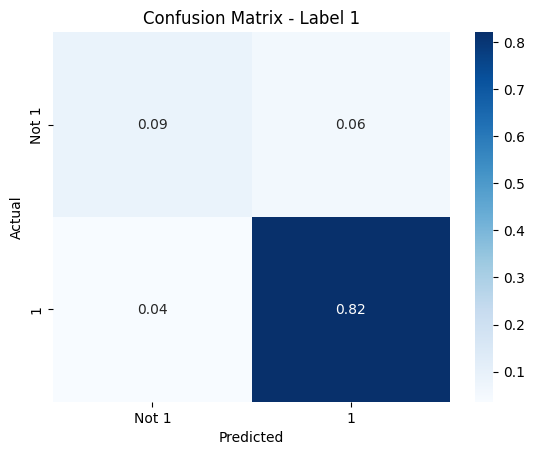

Label: 2
Accuracy,  0.96875
Precision: 0.5
Recall: 0.02564102564102564
F1 Score: 0.048780487804878044
[[   1    1]
 [  38 1208]]


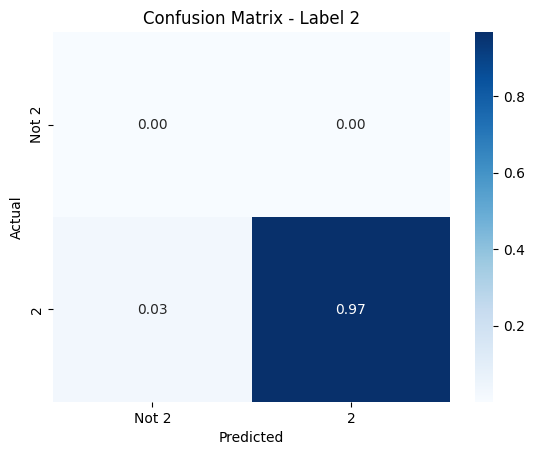

Label: 3
Accuracy,  0.8886217948717948
Precision: 0.9044776119402985
Recall: 0.9548319327731093
F1 Score: 0.9289729177312214
[[909  96]
 [ 43 200]]


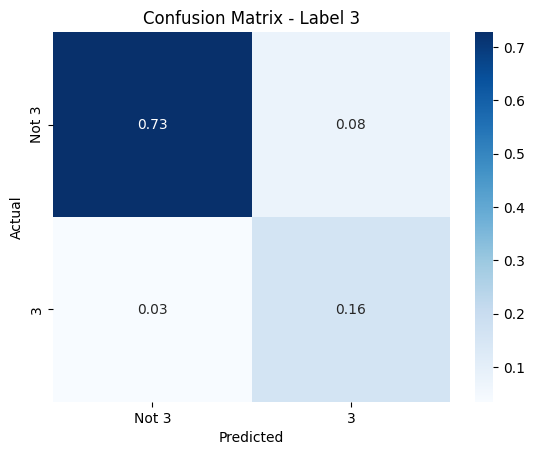

Label: 4
Accuracy,  0.9615384615384616
Precision: 0.9365079365079365
Recall: 0.5728155339805825
F1 Score: 0.710843373493976
[[  59    4]
 [  44 1141]]


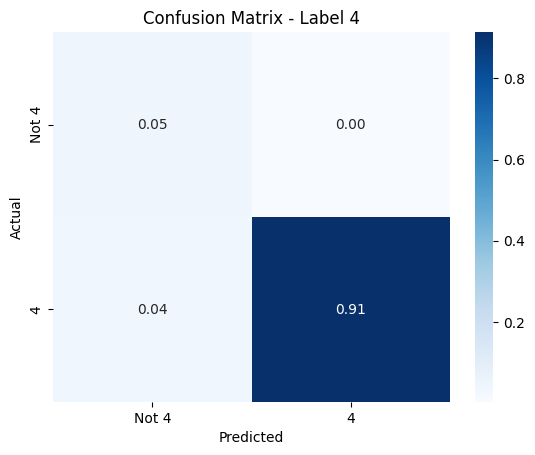

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt
labels = [0 ,1 ,2 ,3]


for label in labels:
    # True Positive (TP): 실제값과 예측값이 모두 해당 레이블인 경우
    tp = sum([r == label and p == label for r,p in zip(real,pred)])

    # False Positive (FP): 실제값은 해당 레이블이 아니지만 예측값은 해당 레이블인 경우
    fp = sum([r != label and p == label for r,p in zip(real,pred)])

    # False Negative (FN): 실제값은 해당 레이블인데 예측값은 해당 레이블이 아닌 경우
    fn = sum([r == label and p != label for r,p in zip(real,pred)])

    # True Negative (TN): 실제값과 예측값 모두 해당 레이블이 아닌 경우
    tn = sum([r != label and p != label for r, p in zip(real, pred)])

    # Accuracy: (TP + TN) / (TP + TN + FP + FN)
    accuracy = (tp + tn) / (tp + tn + fp + fn)

    # Precision: TP / (TP + FP)
    precision = tp / (tp + fp)

    # Recall: TP / (TP + FN)
    recall = tp / (tp + fn)

    # F1 Score: Harmonic mean of Precision and Recall
    f1score = 2 * ((precision * recall) / (precision + recall))

    print("Label:",label+1)
    print("Accuracy, ", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1score)

    matrix = np.array([[tp, fp], [fn, tn]])
    print(matrix)
    # Create a heatmap using seaborn
    ax = sns.heatmap(matrix / np.sum(matrix), annot=True,
                     fmt=".2f", cmap="Blues",
                     xticklabels=['Not '+str(label+1), str(label+1)],
                     yticklabels=['Not '+str(label+1), str(label+1)])
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    title = f"Confusion Matrix - Label {label+1}"
    plt.title(title)
     # Show the plot
    plt.show()



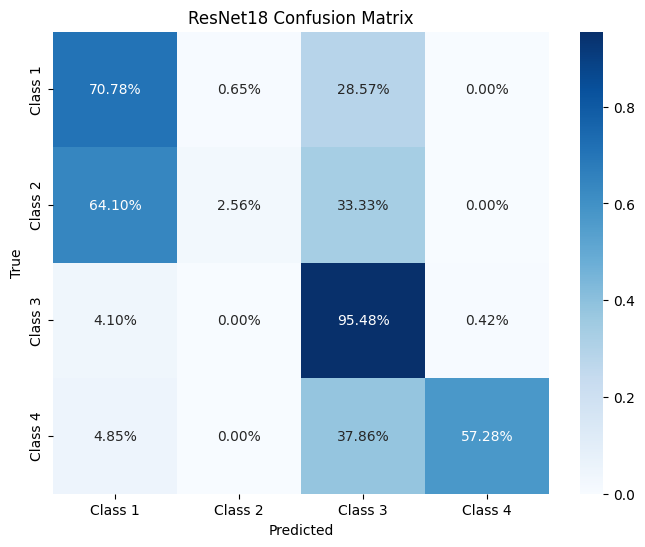

In [ ]:
# 예측 결과와 실제 레이블 추출
predicted_labels =test_preds
true_labels = test_targets

# 전체 혼동 행렬 계산
cm = confusion_matrix(true_labels, predicted_labels, normalize='true')

# Confusion Matrix 시각화
class_names = ['Class 1', 'Class 2', 'Class 3', 'Class 4']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('ResNet18 Confusion Matrix')

plt.show()


In [ ]:
# 모델 평가 및 평가 지표 계산 (테스트 데이터)
test_preds = []
test_targets = []

with torch.no_grad(), tqdm(val_loader, unit="batch") as t:
    for img_parts, labels in t:
        outputs = []
        for part in img_parts:
            # images, labels = images.to(device), labels.to(device)
            part = part.to(device)
            part_outputs = model(part)
            part_outputs = part_outputs.to(device)
            outputs.append(part_outputs)

        outputs = torch.stack(outputs, dim=1).mean(dim=1)
        _, predicted = torch.max(outputs, 1)
        test_targets.extend(labels.cpu().numpy())
        test_preds.extend(predicted.cpu().numpy())
        t.set_postfix(test_accuracy=accuracy_score(test_targets, test_preds))

# 평가 지표 계산 (테스트 데이터)
test_accuracy = accuracy_score(test_targets, test_preds)
test_precision = precision_score(test_targets, test_preds, average='weighted')
test_recall = recall_score(test_targets, test_preds, average='weighted')
test_f1 = f1_score(test_targets, test_preds, average='weighted')

print()
print("Test")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")

100%|██████████| 39/39 [00:07<00:00,  5.02batch/s, test_accuracy=0.861]


Test
Accuracy: 0.8606
Precision: 0.8510
Recall: 0.8606
F1 Score: 0.8487


In [ ]:
class ResNetSteelClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ResNetSteelClassifier, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNetSteelClassifier(num_classes=4).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    with tqdm(train_loader, unit="batch") as t:
        for img_parts, labels in t:
            optimizer.zero_grad()
            outputs = []

            for part in img_parts:
                # images, labels = images.to(device), labels.to(device)
                part = part.to(device)
                part_outputs = model(part)
                part_outputs = part_outputs.to(device)
                outputs.append(part_outputs)

            outputs = torch.stack(outputs, dim=1).mean(dim=1)  # 이미지 부분의 출력 평균
            labels = labels.to(device)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            t.set_postfix(loss=running_loss / (t.n + 1))

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [ ]:
# 학습된 모델 저장
torch.save(model.state_dict(), '/content/drive/MyDrive/졸업과제/모델/ResNet/resnet_18_devide6.pth')

In [ ]:
# 모델 불러오기
model = ResNetSteelClassifier(num_classes=4).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/졸업과제/모델/ResNet/resnet_18_devide6.pth'))
model.eval()

ResNetSteelClassifier(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

In [ ]:
# 모델 평가
preds = []
targets = []

with torch.no_grad(), tqdm(train_loader, unit="batch") as t:
    for img_parts, labels in t:

        optimizer.zero_grad()
        outputs = []

        for part in img_parts:
            # images, labels = images.to(device), labels.to(device)
            part = part.to(device)
            part_outputs = model(part)
            part_outputs = part_outputs.to(device)
            outputs.append(part_outputs)

        outputs = torch.stack(outputs, dim=1).mean(dim=1)
        _, predicted = torch.max(outputs, 1)
        targets.extend(labels.cpu().numpy())
        preds.extend(predicted.cpu().numpy())
        t.set_postfix(accuracy=accuracy_score(targets, preds))

# 평가 지표 계산
accuracy = accuracy_score(targets, preds)
precision = precision_score(targets, preds, average='weighted')
recall = recall_score(targets, preds, average='weighted')
f1 = f1_score(targets, preds, average='weighted')

print()
print("Train")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import numpy as np

# 클래스별 성능 평가 (테스트 데이터)
class_ids = [1, 2, 3, 4]
confusion_matrices = []
for class_id in class_ids:

    class_indices = [i for i in range(len(test_targets)) if test_targets[i] == class_id-1]
    class_preds = [test_preds[i] for i in class_indices]
    class_labels = [test_targets[i] for i in class_indices]
    cm = confusion_matrix(class_labels, np.round(class_preds))
    confusion_matrices.append(cm)

    accuracy = accuracy_score(class_labels, class_preds)
    precision = precision_score(class_labels, class_preds, average='weighted')
    recall = recall_score(class_labels, class_preds, average='weighted')
    f1score = f1_score(class_labels, class_preds, average='weighted')

    print(f"Class {class_id} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1score:.4f}")


Class 1 - Accuracy: 0.6948, Precision: 1.0000, Recall: 0.6948, F1-score: 0.8199
Class 2 - Accuracy: 0.0256, Precision: 1.0000, Recall: 0.0256, F1-score: 0.0500
Class 3 - Accuracy: 0.9485, Precision: 1.0000, Recall: 0.9485, F1-score: 0.9736
Class 4 - Accuracy: 0.6117, Precision: 1.0000, Recall: 0.6117, F1-score: 0.7590


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined 